<a href="https://colab.research.google.com/github/leenoru/titanic_competition/blob/main/230221_titanic_MV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mission
- 타이타닉 데이터를 가져와 id 대비 생존률을 정확하게 맞출 수 있는 모델을 만들기
- 활용 모델 : DecisionTreeClassifier
- 아래와 같이 제작해서 캐글로 제출


In [747]:
# submission = pd.read_csv(args.submission_csv)
# print(f'{submission.shape}')
# submission.head()

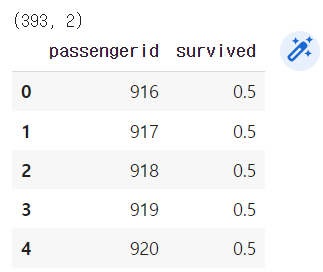

# Connect to google account

In [748]:
from google.colab import drive
import pandas as pd

# 구글 드라이브 마운트
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [749]:
# 코렙 한글깨짐 방지
!apt -qq -y install fonts-nanum > /dev/null

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=fontpath).get_name() 
fm._rebuild()  

%config InlineBackend.figure_format = 'retina'

plt.rc('font', family=font_name)  
plt.rcParams['axes.unicode_minus'] = False

# Global Variables

In [750]:
import easydict
import json
args = easydict.EasyDict()

# path 정보
args.default_path = '/content/gdrive/My Drive/titanic_kaggle/data/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.submission_csv = args.default_path+'submission.csv'

# 데이터 분석을 위한 변수들
args.random_state = 21
SEED = 42

# 컬럼 분류
target_cols = ['survived']
continous_cols = ['age', 'sibsp', 'parch', 'fare']
category_cols = ['pclass', 'gender', 'embarked']
other_cols = ['passengerid', 'name', 'ticket', 'cabin']

In [751]:
['passengerid', 'pclass_2.0', 'pclass_3.0', 'pclass_1.0', 'gender_male',
       'gender_female', 'embarked_S', 'embarked_Q', 'embarked_C', 'age',
       'sibsp', 'parch', 'fare', 'survived']

['passengerid',
 'pclass_2.0',
 'pclass_3.0',
 'pclass_1.0',
 'gender_male',
 'gender_female',
 'embarked_S',
 'embarked_Q',
 'embarked_C',
 'age',
 'sibsp',
 'parch',
 'fare',
 'survived']

# Data Load
- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- Sex:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [752]:
# 데이터 시각화 라이브러리 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [753]:
train = pd.read_csv(args.train_csv) # pd.read_scv()를 통한 데이터 불러오기
print(f'{train.shape}') # 기본적인 shape 확인
train.head()

(916, 12)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [754]:
test = pd.read_csv(args.test_csv)
print(f'{test.shape}')
test.head()

(393, 11)


,passengerid,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,916,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
1,917,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,NaN,S
2,918,3,"McCarthy, Miss. Catherine Katie""""",female,NaN,0,0,383123,7.7500,NaN,Q
3,919,3,"Franklin, Mr. Charles (Charles Fardon)",male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S
4,920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S


In [755]:
train.describe(include = 'all')

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
count,916.000000,916.000000,916.000000,916,916,736.000000,916.000000,916.000000,916,916.000000,198,915
unique,NaN,NaN,NaN,915,2,NaN,NaN,NaN,703,NaN,146,3
top,NaN,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,2,589,NaN,NaN,NaN,7,NaN,4,645
mean,457.500000,0.377729,2.292576,NaN,NaN,29.698370,0.507642,0.361354,NaN,32.402710,NaN,NaN
std,264.570721,0.485084,0.838675,NaN,NaN,14.185627,1.044866,0.828054,NaN,50.506411,NaN,NaN
min,0.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,228.750000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,457.500000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.458300,NaN,NaN
75%,686.250000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,30.017700,NaN,NaN


In [756]:
test.describe(include = 'all')

,passengerid,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
count,393.000000,393.000000,393,393,310.000000,393.000000,393.000000,393,392.000000,97,392
unique,NaN,NaN,393,2,NaN,NaN,NaN,345,NaN,86,3
top,NaN,NaN,"McGowan, Miss. Anna ""Annie""",male,NaN,NaN,NaN,220845,NaN,F4,S
freq,NaN,NaN,1,254,NaN,NaN,NaN,4,NaN,4,269
mean,1112.000000,2.300254,NaN,NaN,30.315065,0.478372,0.440204,NaN,35.381643,NaN,NaN
std,113.593574,0.836919,NaN,NaN,14.955056,1.035180,0.946051,NaN,54.582654,NaN,NaN
min,916.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,1014.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1112.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.281250,NaN,NaN
75%,1210.000000,3.000000,NaN,NaN,40.000000,1.000000,1.000000,NaN,35.125000,NaN,NaN


In [757]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  916 non-null    int64  
 1   survived     916 non-null    int64  
 2   pclass       916 non-null    int64  
 3   name         916 non-null    object 
 4   gender       916 non-null    object 
 5   age          736 non-null    float64
 6   sibsp        916 non-null    int64  
 7   parch        916 non-null    int64  
 8   ticket       916 non-null    object 
 9   fare         916 non-null    float64
 10  cabin        198 non-null    object 
 11  embarked     915 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 86.0+ KB


In [758]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  393 non-null    int64  
 1   pclass       393 non-null    int64  
 2   name         393 non-null    object 
 3   gender       393 non-null    object 
 4   age          310 non-null    float64
 5   sibsp        393 non-null    int64  
 6   parch        393 non-null    int64  
 7   ticket       393 non-null    object 
 8   fare         392 non-null    float64
 9   cabin        97 non-null     object 
 10  embarked     392 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 33.9+ KB


In [759]:
train.isnull().sum().sort_values(ascending = False)

cabin          718
age            180
embarked         1
passengerid      0
survived         0
pclass           0
name             0
gender           0
sibsp            0
parch            0
ticket           0
fare             0
dtype: int64

In [760]:
test.isnull().sum().sort_values(ascending = False)

cabin          296
age             83
fare             1
embarked         1
passengerid      0
pclass           0
name             0
gender           0
sibsp            0
parch            0
ticket           0
dtype: int64

- train 파일에 survived 컬럼이 더 있는 것을 확인
- train, test 둘다 결측치가 있는 것을 확인
- 클린 작업이 필요

# EDA

## Column Classification

In [761]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  916 non-null    int64  
 1   survived     916 non-null    int64  
 2   pclass       916 non-null    int64  
 3   name         916 non-null    object 
 4   gender       916 non-null    object 
 5   age          736 non-null    float64
 6   sibsp        916 non-null    int64  
 7   parch        916 non-null    int64  
 8   ticket       916 non-null    object 
 9   fare         916 non-null    float64
 10  cabin        198 non-null    object 
 11  embarked     915 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 86.0+ KB


In [762]:
train.describe(include = 'all')

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
count,916.000000,916.000000,916.000000,916,916,736.000000,916.000000,916.000000,916,916.000000,198,915
unique,NaN,NaN,NaN,915,2,NaN,NaN,NaN,703,NaN,146,3
top,NaN,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,2,589,NaN,NaN,NaN,7,NaN,4,645
mean,457.500000,0.377729,2.292576,NaN,NaN,29.698370,0.507642,0.361354,NaN,32.402710,NaN,NaN
std,264.570721,0.485084,0.838675,NaN,NaN,14.185627,1.044866,0.828054,NaN,50.506411,NaN,NaN
min,0.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,228.750000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,457.500000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.458300,NaN,NaN
75%,686.250000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,30.017700,NaN,NaN


In [763]:
train['cabin'].unique().shape

(147,)

In [764]:
# 컬럼 분류
target_cols = ['survived']
continous_cols = ['age', 'sibsp', 'parch', 'fare']
category_cols = ['pclass', 'gender', 'embarked']
other_cols = ['passengerid', 'name', 'ticket', 'cabin']

## Missing Value

In [765]:
train.isnull().sum().sort_values(ascending = False)

cabin          718
age            180
embarked         1
passengerid      0
survived         0
pclass           0
name             0
gender           0
sibsp            0
parch            0
ticket           0
fare             0
dtype: int64

In [766]:
test.isnull().sum().sort_values(ascending = False)

cabin          296
age             83
fare             1
embarked         1
passengerid      0
pclass           0
name             0
gender           0
sibsp            0
parch            0
ticket           0
dtype: int64

### continous_cols
- age, fare

In [767]:
train['age'].fillna(train['age'].median(), inplace=True)
test['age'].fillna(train['age'].median(), inplace=True)
train['fare'].fillna(train['fare'].mean(), inplace=True)
test['fare'].fillna(train['fare'].mean(), inplace=True)

train[['age', 'fare']].isnull().sum()

age     0
fare    0
dtype: int64

In [768]:
train['age'].isnull()

0      False
1      False
2      False
3      False
4      False
       ...  
911    False
912    False
913    False
914    False
915    False
Name: age, Length: 916, dtype: bool

In [769]:
test[['age', 'fare']].isnull().sum()

age     0
fare    0
dtype: int64

### category_cols
- embarked

In [770]:
embarked_mode = train['embarked'].mode().values[0]

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)

In [771]:
train['embarked'].isnull().sum()

0

In [772]:
test['embarked'].isnull().sum()

0

### other_cols

In [773]:
cabin_mode = train['cabin'].mode().values[0]

train['cabin'].fillna(cabin_mode, inplace=True)
test['cabin'].fillna(cabin_mode, inplace=True)

In [774]:
train['cabin'].isnull().sum()

0

In [775]:
test['cabin'].isnull().sum()

0

In [776]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

In [777]:
print(f'{train.shape} / {test.shape}')

(916, 12) / (393, 11)


# Scaling

In [778]:
from sklearn.preprocessing import StandardScaler

In [779]:
continous_cols = ['age', 'sibsp', 'parch', 'fare']
train[continous_cols]

,age,sibsp,parch,fare
0,28.0,0,0,12.8750
1,28.0,0,0,7.7500
2,52.0,1,1,93.5000
3,27.0,0,0,7.7958
4,44.0,1,0,26.0000
...,...,...,...,...
911,28.0,1,0,6.4375
912,18.0,0,0,8.6625
913,19.0,0,0,10.5000
914,28.0,0,0,7.7333


In [780]:
continous_cols = ['age', 'sibsp', 'parch', 'fare']

from sklearn.preprocessing import StandardScaler

std = StandardScaler()

train[continous_cols] = std.fit_transform(train[continous_cols])
test[continous_cols] = std.transform(test[continous_cols])


In [781]:
train[continous_cols]

,age,sibsp,parch,fare
0,-0.107240,-0.486109,-0.436627,-0.386849
1,-0.107240,-0.486109,-0.436627,-0.488377
2,1.778818,0.471474,0.771683,1.210355
3,-0.185826,-0.486109,-0.436627,-0.487470
4,1.150132,0.471474,-0.436627,-0.126840
...,...,...,...,...
911,-0.107240,0.471474,-0.436627,-0.514378
912,-0.893098,-0.486109,-0.436627,-0.470300
913,-0.814512,-0.486109,-0.436627,-0.433899
914,-0.107240,-0.486109,-0.436627,-0.488708


# Encoding

In [782]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [783]:
import category_encoders as ce

In [784]:
train[category_cols]

,pclass,gender,embarked
0,2,male,S
1,3,female,Q
2,1,female,S
3,3,male,S
4,2,male,S
...,...,...,...
911,3,male,C
912,3,male,S
913,2,male,S
914,3,female,Q


In [785]:
encoder = ce.OneHotEncoder(use_cat_names = True)
enco_tr = pd.DataFrame()
enco_te = pd.DataFrame()

for col in train[category_cols].columns:
  _enco = encoder.fit_transform(train[col].astype('category'))
  enco_tr = pd.concat([enco_tr, _enco], axis=1)

  _enco = encoder.transform(test[col].astype('category'))
  enco_te = pd.concat([enco_te, _enco], axis=1)

In [786]:
enco_tr.head()

,pclass_2.0,pclass_3.0,pclass_1.0,gender_male,gender_female,embarked_S,embarked_Q,embarked_C
0,1,0,0,1,0,1,0,0
1,0,1,0,0,1,0,1,0
2,0,0,1,0,1,1,0,0
3,0,1,0,1,0,1,0,0
4,1,0,0,1,0,1,0,0


In [787]:
enco_te.head()

,pclass_2.0,pclass_3.0,pclass_1.0,gender_male,gender_female,embarked_S,embarked_Q,embarked_C
0,0,1,0,0,1,0,1,0
1,1,0,0,0,1,1,0,0
2,0,1,0,0,1,0,1,0
3,0,1,0,1,0,1,0,0
4,0,0,1,0,1,1,0,0


In [788]:
print(f'{enco_tr.shape} / {enco_te.shape}')

(916, 8) / (393, 8)


# train_test_split

In [789]:
df_train = pd.concat([enco_tr, train[continous_cols], train['survived']], axis = 1)
df_test = pd.concat([enco_te, test[continous_cols]], axis = 1)

In [790]:
df_train.shape, df_test.shape

((916, 13), (393, 12))

In [791]:
df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

In [792]:
df_train.corr()

,pclass_2.0,pclass_3.0,pclass_1.0,gender_male,gender_female,embarked_S,embarked_Q,embarked_C,age,sibsp,parch,fare,survived
pclass_2.0,1.000000,-0.562074,-0.297533,-0.015306,0.015306,0.212050,-0.142625,-0.138846,0.015278,-0.060083,-0.026160,-0.123377,0.014994
pclass_3.0,-0.562074,1.000000,-0.622393,0.103827,-0.103827,0.013963,0.248658,-0.190189,-0.321986,0.083313,0.061222,-0.404621,-0.216771
pclass_1.0,-0.297533,-0.622393,1.000000,-0.105363,0.105363,-0.216788,-0.152055,0.350932,0.357212,-0.039310,-0.045913,0.583814,0.236031
gender_male,-0.015306,0.103827,-0.105363,1.000000,-1.000000,0.118012,-0.113033,-0.053658,0.060446,-0.102554,-0.219813,-0.163040,-0.702553
gender_female,0.015306,-0.103827,0.105363,-1.000000,1.000000,-0.118012,0.113033,0.053658,-0.060446,0.102554,0.219813,0.163040,0.702553
embarked_S,0.212050,0.013963,-0.216788,0.118012,-0.118012,1.000000,-0.481763,-0.788675,-0.052979,0.064345,0.062394,-0.209283,-0.148229
embarked_Q,-0.142625,0.248658,-0.152055,-0.113033,0.113033,-0.481763,1.000000,-0.158805,-0.023882,-0.048305,-0.094176,-0.115714,0.074584
embarked_C,-0.138846,-0.190189,0.350932,-0.053658,0.053658,-0.788675,-0.158805,1.000000,0.076446,-0.038606,-0.004224,0.316979,0.114679
age,0.015278,-0.321986,0.357212,0.060446,-0.060446,-0.052979,-0.023882,0.076446,1.000000,-0.204688,-0.145331,0.138298,-0.024610
sibsp,-0.060083,0.083313,-0.039310,-0.102554,0.102554,0.064345,-0.048305,-0.038606,-0.204688,1.000000,0.386491,0.162144,0.002924


In [793]:
from sklearn.model_selection import train_test_split

In [794]:
df_train.columns

Index(['pclass_2.0', 'pclass_3.0', 'pclass_1.0', 'gender_male',
       'gender_female', 'embarked_S', 'embarked_Q', 'embarked_C', 'age',
       'sibsp', 'parch', 'fare', 'survived'],
      dtype='object')

In [795]:
df_train.head()

,pclass_2.0,pclass_3.0,pclass_1.0,gender_male,gender_female,embarked_S,embarked_Q,embarked_C,age,sibsp,parch,fare,survived
0,1,0,0,1,0,1,0,0,-0.107240,-0.486109,-0.436627,-0.386849,0
1,0,1,0,0,1,0,1,0,-0.107240,-0.486109,-0.436627,-0.488377,0
2,0,0,1,0,1,1,0,0,1.778818,0.471474,0.771683,1.210355,1
3,0,1,0,1,0,1,0,0,-0.185826,-0.486109,-0.436627,-0.487470,1
4,1,0,0,1,0,1,0,0,1.150132,0.471474,-0.436627,-0.126840,0


In [796]:
tmp = ['pclass_2.0', 'pclass_3.0', 'pclass_1.0', 'gender_male',
       'gender_female', 'age', 'embarked_S', 'embarked_Q', 'embarked_C', 'fare']
X = df_train[tmp]
y = df_train['survived']
df_test = df_test[tmp]

X.shape, y.shape, df_test.shape

((916, 10), (916,), (393, 10))

In [797]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2, random_state=SEED)
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((732, 10), (184, 10), (732,), (184,))

In [798]:
X_tr.isnull().sum().sum(), X_te.isnull().sum().sum(), y_tr.isnull().sum().sum(), y_te.isnull().sum().sum()

(0, 0, 0, 0)

# ModelV2

In [799]:
X_tr_modelV0 = X_tr.copy()
X_te_modelV0 = X_te.copy()
y_tr_modelV0 = y_tr.copy()
y_te_modelV0 = y_te.copy()

X_tr_modelV0.shape, X_te_modelV0.shape, y_tr_modelV0.shape, y_te_modelV0.shape

((732, 10), (184, 10), (732,), (184,))

In [800]:
from sklearn.tree import DecisionTreeClassifier

In [801]:
hp = {
    "random_state":SEED,
    "max_depth":5
}

modelV0 = DecisionTreeClassifier(**hp)
modelV0.fit(X_tr_modelV0, y_tr_modelV0) #학습데이터, 타겟데이터

DecisionTreeClassifier(max_depth=5, random_state=42)

In [802]:
from sklearn.metrics import roc_curve, auc

In [803]:
pred = modelV0.predict_proba(X_te_modelV0)[:, 1]

In [804]:
fpr, tpr, _ = roc_curve(y_te_modelV0, pred) 

In [805]:
auc(fpr, tpr)

0.8703007518796992

In [806]:
test_pred = modelV0.predict_proba(df_test)[:, 1]
test_pred.shape

(393,)

In [807]:
test_pred[:3]

array([0.93333333, 0.81818182, 0.93333333])

In [808]:
submission = pd.read_csv(args.submission_csv)

In [809]:
X_te_modelV0.columns

Index(['pclass_2.0', 'pclass_3.0', 'pclass_1.0', 'gender_male',
       'gender_female', 'age', 'embarked_S', 'embarked_Q', 'embarked_C',
       'fare'],
      dtype='object')

In [810]:
df_feature_importances = pd.DataFrame(modelV0.feature_importances_)

df_feature_importances

,0
0,0.000000
1,0.057290
2,0.023768
3,0.000000
4,0.764050
5,0.039672
6,0.000000
7,0.008083
8,0.000000
9,0.107137


In [811]:
submission['survived'] = test_pred
submission.head()

,passengerid,survived
0,916,0.933333
1,917,0.818182
2,918,0.933333
3,919,0.081340
4,920,0.928571


In [812]:
submission.to_csv(args.submission_csv, header=True, index=False)

In [813]:
test_pred

array([0.93333333, 0.81818182, 0.93333333, 0.08133971, 0.92857143,
       0.88888889, 0.03125   , 0.08133971, 0.6440678 , 0.03125   ,
       0.03125   , 0.        , 0.6440678 , 0.6440678 , 0.03125   ,
       0.33333333, 0.        , 0.03125   , 0.08133971, 0.08133971,
       0.08133971, 0.03125   , 0.08133971, 0.03125   , 0.08133971,
       0.08133971, 0.33333333, 0.6440678 , 0.33333333, 0.        ,
       0.6440678 , 0.6440678 , 0.        , 0.33333333, 0.33333333,
       0.08133971, 1.        , 0.03125   , 0.33333333, 0.08133971,
       0.08133971, 1.        , 0.08133971, 1.        , 0.03125   ,
       0.03125   , 0.33333333, 0.03125   , 0.08133971, 0.03125   ,
       0.5       , 0.        , 1.        , 0.08133971, 0.6440678 ,
       0.93333333, 0.        , 0.08133971, 0.03125   , 0.5       ,
       1.        , 0.6440678 , 0.93333333, 0.03125   , 0.03125   ,
       0.03125   , 0.33333333, 0.88888889, 0.08133971, 1.        ,
       0.08133971, 1.        , 0.6440678 , 1.        , 0.03125